# Wake Migration

This notebook demonstrates the workload behaviour when tasks are woke up

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '10.169.36.55',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_switch",
            'dequeue_task_fair', 
            'enqueue_task_fair', 
            'set_next_entity',

                    
            "cpu_capacity",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "lisa_wake_migration",
}

In [4]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

03:45:40  INFO    :         Target - Using base path: /data/lisa_fork/lisa
03:45:40  INFO    :         Target - Loading custom (inline) target configuration
03:45:40  INFO    :         Target - Loading custom (inline) test configuration
03:45:40  INFO    :         Target - External tools using:
03:45:40  INFO    :         Target -    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
03:45:40  INFO    :         Target -    CATAPULT_HOME: /data/lisa_fork/lisa/tools/catapult
03:45:40  INFO    :         Target - Devlib modules to load: ['bl', 'hwmon', 'cpufreq']
03:45:40  INFO    :         Target - Connecting Android target [10.169.36.55:5555]
03:45:40  INFO    :         Target - Connection settings:
03:45:40  INFO    :         Target -    {'device': '10.169.36.55:5555'}
03:45:42  INFO    :         Target - Initializing target workdir:
03:45:42  INFO    :         Target -    /data/local/tmp/devlib-target
03:45:50  INFO    :         Target - Topology:
03:45:50  INFO    :         Target -  

# Workload configuration

In [5]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
         'wake_mig_0': Ramp(
            start_pct=10,           # intial load
            end_pct=50,            # end load
            delta_pct=40,          # load % increase...
            time_s=5,              # ... every 1[s]
            loops=2,
        ).get(),
         'wake_mig_1': Ramp(
            start_pct=10,           # intial load
            end_pct=50,            # end load
            delta_pct=40,          # load % increase...
            time_s=5,              # ... every 1[s]
            #delay_s=0.05,          # delay time to execute
            loops=2,
        ).get(),
    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

03:45:51  INFO    :          WlGen - Setup new workload simple
03:45:51  INFO    :          RTApp - Workload duration defined by longest task
03:45:51  INFO    :          RTApp - Default policy: SCHED_OTHER
03:45:51  INFO    :          RTApp - ------------------------
03:45:52  INFO    :          RTApp - task [wake_mig_0], sched: using default policy
03:45:52  INFO    :          RTApp -  | calibration CPU: 1
03:45:52  INFO    :          RTApp -  | loops count: 2
03:45:52  INFO    :          RTApp - + phase_000001: duration 5.000000 [s] (50 loops)
03:45:52  INFO    :          RTApp - |  period   100000 [us], duty_cycle  10 %
03:45:52  INFO    :          RTApp - |  run_time  10000 [us], sleep_time  90000 [us]
03:45:52  INFO    :          RTApp - + phase_000002: duration 5.000000 [s] (50 loops)
03:45:52  INFO    :          RTApp - |  period   100000 [us], duty_cycle  50 %
03:45:52  INFO    :          RTApp - |  run_time  50000 [us], sleep_time  50000 [us]
03:45:52  INFO    :          RTAp

# Workload execution

In [6]:
target.cpufreq.set_all_governors('sched')

logging.info("Current scheduling governor of target board is sched")
#os.system("cat /sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")

03:45:52  INFO    : Current scheduling governor of target board is sched


In [7]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
(nrg, nrg_file) = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

03:46:04  INFO    : #### Setup FTrace
03:46:06  INFO    : #### Start energy sampling
03:46:06  INFO    : #### Start RTApp execution
03:46:06  INFO    :          WlGen - Workload execution START:
03:46:06  INFO    :          WlGen -    /data/local/tmp/bin/rt-app /data/local/tmp/devlib-target/simple_00.json 2>&1
03:46:27  INFO    : #### Read energy consumption: /data/lisa_fork/lisa/results/lisa_wake_migration/energy.json
03:46:27  INFO    : #### Stop FTrace
03:46:27  INFO    : #### Save FTrace: /data/lisa_fork/lisa/results/lisa_wake_migration/trace.dat
03:46:30  INFO    : #### Save platform description: /data/lisa_fork/lisa/results/lisa_wake_migration/platform.json


# Collected results

In [8]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

03:49:16  INFO    : Content of the output folder /data/lisa_fork/lisa/results/lisa_wake_migration


total 7240
drwxrwxr-x  2 zhifei zhifei    4096 1月  10 15:46 .
drwxrwxr-x 15 zhifei zhifei    4096 1月  10 15:45 ..
-rw-rw-r--  1 zhifei zhifei      67 1月  10 15:46 energy.json
-rw-rw-r--  1 zhifei zhifei     307 1月  10 15:46 output.log
-rw-rw-r--  1 zhifei zhifei    1075 1月  10 15:46 platform.json
-rw-r--r--  1 zhifei zhifei   24960 1月  10 15:46 rt-app-wake_mig_0-0.log
-rw-r--r--  1 zhifei zhifei   24960 1月  10 15:46 rt-app-wake_mig_1-1.log
-rw-r--r--  1 zhifei zhifei    1465 1月  10 15:46 simple_00.json
-rw-r--r--  1 zhifei zhifei 7331840 1月  10 15:46 trace.dat


In [9]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

03:49:16  INFO    : Generated RTApp JSON file:


In [10]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_file)
print json.dumps(nrg, indent=4, sort_keys=True)

03:49:17  INFO    : Energy: /data/lisa_fork/lisa/results/lisa_wake_migration/energy.json


{
    "LITTLE": 1.1102370000000974, 
    "big": 8.954449999999952
}


In [11]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

03:49:18  INFO    : Platform description: /data/lisa_fork/lisa/results/lisa_wake_migration/platform.json


# Trace inspection

In [12]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# New Task Behavior

In [13]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=['wake_mig_0', "wake_mig_1"])

03:49:27  INFO    : Parsing FTrace format...
03:49:30  WARNING : Cluster Frequency is not coherent! Failure in [cpu_frequency] events at:
03:49:30  WARNING :             __comm  __cpu  __pid  cpu  frequency
Time                                            
21.172486  shutils      3   2784    0     850000
21.172889  shutils      3   2784    3     575000
21.173012  shutils      3   2784    4     575000
21.173134  shutils      3   2784    5     575000
03:49:30  INFO    : Collected events spans a 21.294 [s] time interval
03:49:30  INFO    : Set plots time range to (0.000000, 21.294298)[s]
03:49:30  INFO    : Registering trace analysis modules:
03:49:30  INFO    :    tasks
03:49:30  INFO    :    idle
03:49:30  INFO    :    latency
03:49:30  INFO    :    functions
03:49:30  INFO    :    frequency
03:49:30  INFO    :    status
03:49:30  INFO    :    eas
03:49:30  INFO    :    cpus


# RTApp task performance plots

02:59:39  INFO    : PerfIndex, Task [wake_mig_1] avg: 0.90, std: 0.09
02:59:40  INFO    : PerfIndex, Task [wake_mig_0] avg: 0.92, std: 0.08


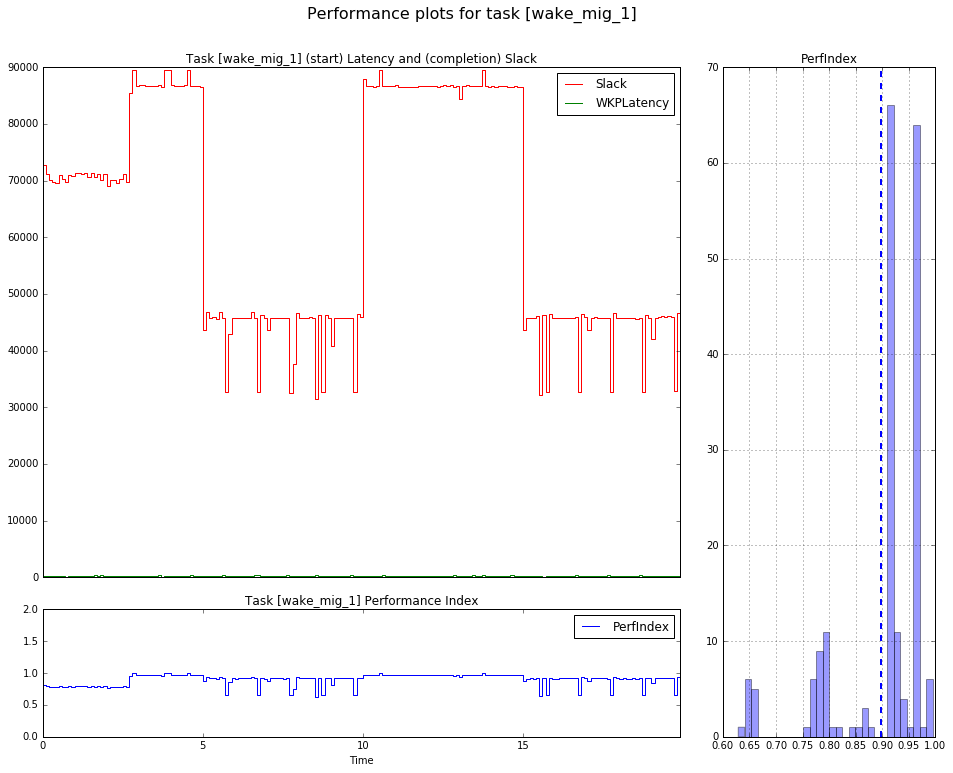

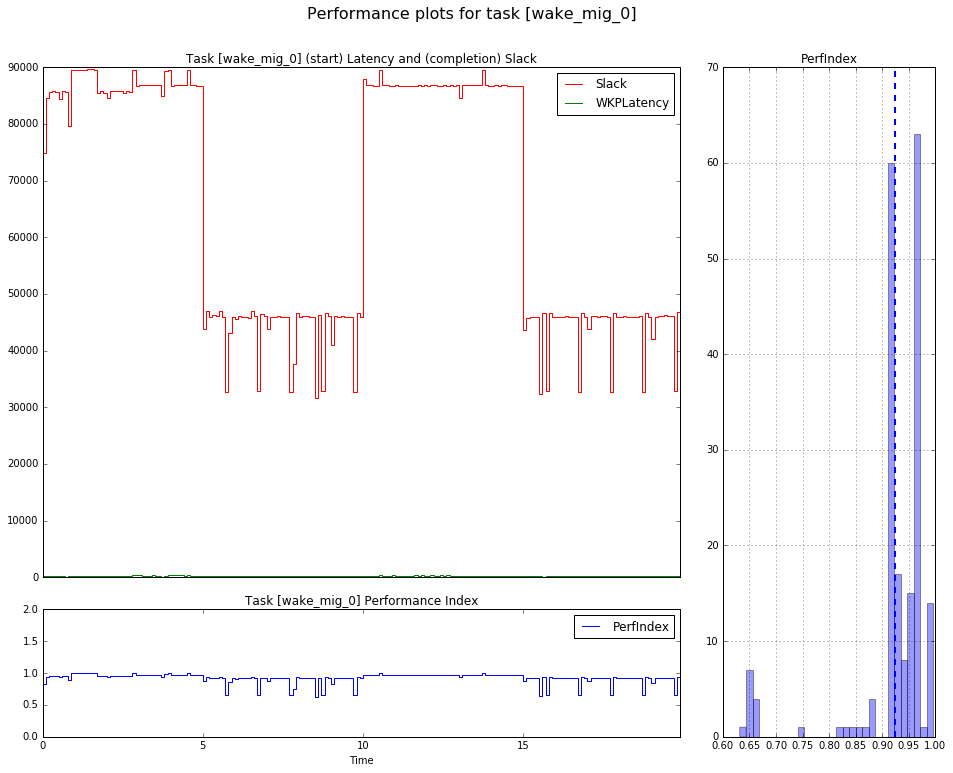

In [37]:
# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Parse the RT-App generate log files to compute performance metrics
pa = PerfAnalysis(te.res_dir)

# For each task which has generated a logfile, plot  its performance metrics
for task in pa.tasks():
    pa.plotPerf(task, "Performance plots for task [{}] ".format(task))

# Trace Overview

In [38]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(ftrace)

In [39]:
# Add column with util_max = max(util_avg, util_est)
df = ftrace.sched_load_avg_cpu.data_frame

#print df[['util_avg', 'util_est']]
#print df[['util_avg']]

#df['util_max'] = df[['util_avg', 'util_est']].max(axis=1)

df['util_max'] = df[['util_avg']].max(axis=1)

In [27]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(ftrace, execnames=['wake_mig_0', 'wake_mig_1',])

# Task Utilization

In [37]:
# These two paramatere are passed to the LinePlot call as long with the
# TRAPpy Run object
trappy.ILinePlot(
    ftrace,                         # TRAPpy RUN object
    signals=[
      'sched_load_avg_task:load_avg',
      'sched_load_avg_task:util_avg'
    ],
    pivot='pid',
    filters={'comm': ['wake_mig_0', 'wake_mig_1']},
    drawstyle='steps-post',
     sync_zoom=True,
     group='PeriodicAndRamp',
    marker = '+').view()

,
,


# CPU Utilization

In [38]:
trappy.ILinePlot(
    ftrace,
    signals=[
      'sched_load_avg_cpu:load_avg',
      #'sched_load_avg_cpu:util_est',
      'sched_load_avg_cpu:util_avg',
    ],
    pivot='cpu',
    filters={'cpu': [1, 2]},
    drawstyle='steps-post',
    scatter=False,
     sync_zoom=True,
     group='PeriodicAndRamp',
    marker = '+').view()

,
,


# CPUfreq

03:36:49  WARNING : Event [sched_overutilized] not found, plot DISABLED!
03:36:49  WARNING : Event [sched_overutilized] not found, plot DISABLED!
03:36:49  INFO    : LITTLE cluster average frequency: 0.569 GHz
03:36:49  INFO    : big    cluster average frequency: 0.737 GHz


(0.56896760814649094, 0.73673362342032689)

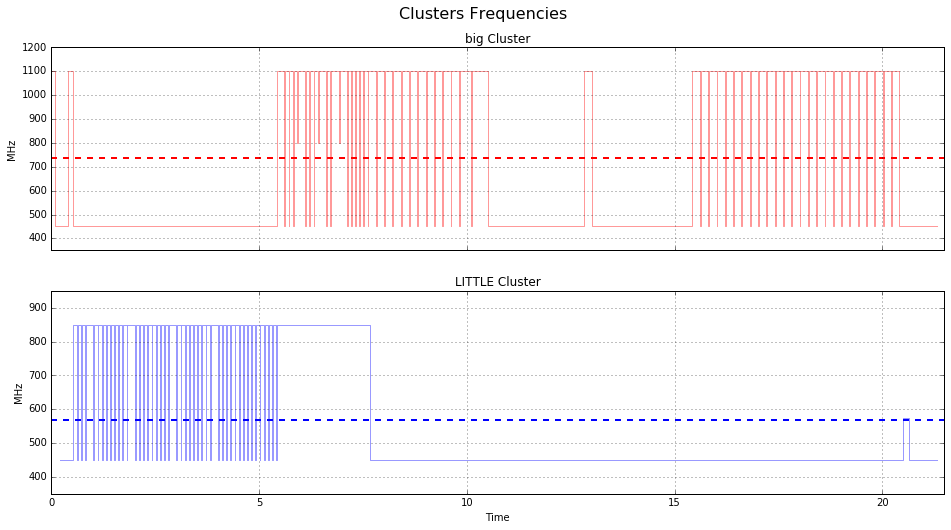

In [19]:
import trace_analysis


#from trace_analysis import plotClusterFrequencies

#ta = TraceAnalysis(te.res_dir)

trace.analysis.frequency.plotClusterFrequencies()

#plotdir(te.res_dir, plt)